****

In [2]:
## This file filters chess games from a Lichess database based on player ratings, game length, and time control. 
## It extracts games between 1500-1700 rated players that last at least 25 moves, excluding bullet games.
## The output is used by the chess count quiz app.

In [4]:
import zstandard as zstd
import io
import chess
import chess.pgn
import json

In [77]:
# Settings
input_filename = "lichess_db_standard_rated_2016-01.pgn.zst"
output_filename_base = "selected_games"
output_weights_fn_base = "selected_weights"
total_games = 500

In [6]:
def get_filtered_games():
    """
    Open the game database and return filtered games
    """
    filtered_games = []
    
    # Open and decompress the .zst file
    with open(input_filename, 'rb') as compressed:
        dctx = zstd.ZstdDecompressor()
        
        with dctx.stream_reader(compressed) as reader:
            # Wrap the reader in a TextIOWrapper for decoding
            text_stream = io.TextIOWrapper(reader, encoding='utf-8')
        
            # Loop over each game in the PGN file
            while True:
                game = chess.pgn.read_game(text_stream)
                if game is None:
                    break  # End of file reached
                
                # Get time control and check if it's bullet
                time_control = game.headers.get("TimeControl", "")
                if time_control.startswith("60") or time_control.startswith("120"):
                    # 1+0 or 2+0; Skip bullet games
                    continue
                
                # Get ratings for white and black
                try:
                    white_rating = int(game.headers.get("WhiteElo", "0"))
                    black_rating = int(game.headers.get("BlackElo", "0"))
                except ValueError:
                    continue  # Skip if ratings are missing or invalid
                
                # Filter for ratings between 1500 and 1700 (both players)
                if not (1500 <= white_rating <= 1700 and 1500 <= black_rating <= 1700):
                    continue
            
                # Count the number of moves played in the game
                move_count = 0
                node = game
                while node.variations:
                    node = node.variations[0]
                    move_count += 1
                # Check that the game lasts at least a certain number moves/plies
                if move_count < 20 * 2:
                    continue
                    
                # If all filters pass, add the game to the list
                filtered_games.append(game)
                if len(filtered_games) >= total_games:
                    break
                
    return filtered_games

In [49]:
filtered_games = get_filtered_games()
print("Games downloaded")

Games downloaded


In [53]:
def write_games(filtered_games):
    output_filename = output_filename_base + ".pgn"
    with open(output_filename, "w", encoding="utf-8") as outfile:
        for game in filtered_games:
            exporter = chess.pgn.StringExporter(headers=True, variations=False, comments=False)
            pgn_text = game.accept(exporter)
            outfile.write(pgn_text + "\n\n")
    
    print(f"Extracted {len(filtered_games)} games and saved to {output_filename}")

In [54]:
write_games(filtered_games)
print("Games written")

Extracted 500 games and saved to selected_games.pgn
Games written


### class PlyStats:

"""Hold some stats on the current ply of game

In [55]:
class PlyStats:
    """Hold some stats on the current ply of game
    
    checks and captures indicate how many different moves, from the
    current position, there are that would result in a check or
    capture.
    """
    def __init__(self):
        self.white_moves = 0
        self.white_checks = 0
        self.white_captures = 0
        self.black_moves = 0
        self.black_checks = 0
        self.black_captures = 0
        self.in_check = False
        self.castling_rights = False
        self.en_passant_rights = False

class GameStats:
    """
    Dictionary from ply index to PlyStats
    """
    def __init__(self, d):
        assert isinstance(d, dict)
        self.d = d
        
    def __getitem__(self, key):
        return self.d[key]

In [56]:
def get_game_stats(game, start_ply=20, end_ply=100):
    """
    Returns dictionary of stats for the given game ply_index -> PlyStats object
    """
    board = game.board()
    ply_index = 0
    node = game
    
    result = {}
    
    while node.variations:
        move = node.variation(0).move
        board.push(move)
        ply_index += 1
    
        if start_ply <= ply_index <= end_ply:
            is_white = board.turn == chess.BLACK  # Because the move has just been made
            
            stats = PlyStats()
            
            stats.white_moves, stats.white_checks, stats.white_captures = move_counts(board, flip=is_white)
            stats.black_moves, stats.black_checks, stats.black_captures = move_counts(board, flip=not is_white)
                
            stats.in_check = board.is_check()
            if (board.has_castling_rights(chess.WHITE) or
                board.has_castling_rights(chess.BLACK)): 
                stats.castling_rights = True
            if board.ep_square is not None:
                stats.en_passant_rights = True
            
            result[ply_index] = stats
        node = node.variations[0]
        
    print(".", end="")
    return GameStats(result)

In [57]:
def move_counts(board, flip=False):
    """
    Return move counts for given board position
    """
    # Copy the board so the original isn't modified
    board_copy = board.copy()
    
    if flip: # Switch the turn to the opponent
        board_copy.turn = not board_copy.turn

    total_legal_moves = 0
    captures = 0
    checks = 0

    for move in board_copy.legal_moves:
        total_legal_moves += 1
        if board_copy.is_capture(move):
            captures += 1
        # Make a new copy to test the result of the move
        test_board = board_copy.copy()
        test_board.push(move)
        if test_board.is_check():
            checks += 1

    return total_legal_moves, checks, captures

In [58]:
print(get_game_stats(filtered_games[0])[20].__dict__)

.{'white_moves': 41, 'white_checks': 0, 'white_captures': 5, 'black_moves': 40, 'black_checks': 0, 'black_captures': 2, 'in_check': False, 'castling_rights': True, 'en_passant_rights': False}


In [59]:
all_stats = [get_game_stats(game) for game in filtered_games]
print("Game stats computed")

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Game stats computed


In [65]:
def calc_ply_weight(ply_stats):
    """
    Calc the weight of a board position
    
    Weight here is proportional to probability.
    The idea is to make more interesting positions occur more frequently
    to the user.
    """
    if ply_stats.castling_rights or ply_stats.in_check or ply_stats.en_passant_rights:
        return .0
    
    return (1
            + ply_stats.white_checks + ply_stats.white_captures
            + ply_stats.black_checks + ply_stats.black_captures)**.5

calc_ply_weight(all_stats[0][26])

2.449489742783178

In [68]:
def calc_game_weights(gs_list):
    result = []
    for i, gs in enumerate(gs_list):
        for ply_index, ps in gs.d.items():
            weight = calc_ply_weight(ps)
            if weight > 0:
                result.append({"game":i, "ply":ply_index, "weight":weight})
    return result

game_weights = calc_game_weights(all_stats)
print("Game weights computed")

Game weights computed


In [73]:
print(len(game_weights))
print(game_weights[172])

all_stats[5][63].__dict__

18936
{'game': 5, 'ply': 63, 'weight': 1.7320508075688772}


{'white_moves': 29,
 'white_checks': 1,
 'white_captures': 0,
 'black_moves': 38,
 'black_checks': 1,
 'black_captures': 0,
 'in_check': False,
 'castling_rights': False,
 'en_passant_rights': False}

Make sure that one game doesn't dominate the data set, and the weights look ok

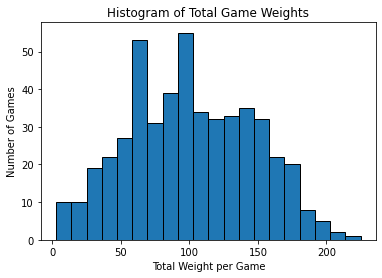

In [74]:
import matplotlib.pyplot as plt
from collections import defaultdict

grouped_weights = defaultdict(float)

for row in game_weights:
    grouped_weights[row["game"]] += row["weight"]

# Create a list of total weights for each game.
total_weights = list(grouped_weights.values())

# Plot the histogram of the total weights.
plt.hist(total_weights, bins=20, edgecolor='black')
plt.xlabel('Total Weight per Game')
plt.ylabel('Number of Games')
plt.title('Histogram of Total Game Weights')
plt.show()

(array([ 507., 2062., 1758., 4323., 4129., 3814., 1643.,  567.,  118.,
          15.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

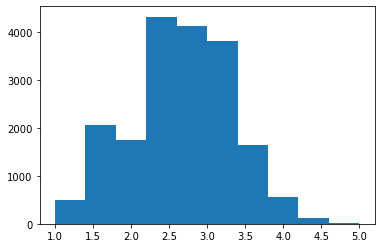

In [75]:
plt.hist([d["weight"] for d in game_weights])

Save the results to disk

In [84]:
def write_game_weights(game_weights):
    output_filename = output_weights_fn_base + ".json"
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(game_weights, f, indent=2)
    print(f"Saved {len(game_weights)} to {output_filename}")

In [85]:
write_game_weights(game_weights)
print("Game weights written")

Saved 18936 to selected_weights.json
Game weights written


In [86]:
print(f"Total games processed: {len(filtered_games)}")

Total games processed: 500
